In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# List all physical devices
physical_devices = tf.config.list_physical_devices()
print("Physical devices:", physical_devices)

# Check for GPU specifically
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
else:
    print("GPU is NOT available.")

2024-03-04 22:58:29.957282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available.


2024-03-04 22:58:30.672227: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-04 22:58:30.672716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-04 22:58:30.708505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-04 22:58:30.708607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.65GHz coreCount: 34 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.29GiB/s
2024-03-04 22:58:30.708628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-04 22:58:30.709696: I tensorflow/stream_executor/platfo

In [2]:
# Load your dataset
dataset = pd.read_csv('../../../Dataset/Exoskeleton/Top_LDA_dataset.csv')
dataset.iloc[:, -1] = dataset.iloc[:, -1]
X = dataset.iloc[:, :-1]  # Features
y = dataset.iloc[:, -1] -1  # Target
y

0       0
1       0
2       0
3       0
4       0
       ..
1828    2
1829    2
1830    2
1831    2
1832    2
Name: fatigue_level, Length: 1833, dtype: int64

In [3]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert labels to categorical
y_categorical = to_categorical(y)
X_scaled

array([[-0.88253618, -0.17465001,  0.1676802 , ...,  1.09937536,
         0.34128161,  0.24996466],
       [ 0.03366521, -0.10762837, -0.12990283, ...,  0.83031045,
         0.28636473,  0.22695286],
       [ 0.80775874,  0.10301201,  0.1902082 , ...,  0.68522387,
         0.26815925,  0.22594069],
       ...,
       [-0.88940277, -0.47338305,  0.06829984, ..., -0.95987318,
        -0.63604986, -0.60281746],
       [-0.88951171, -0.67649489,  0.08822565, ..., -0.96113445,
        -0.6334484 , -0.60039413],
       [-0.88950583, -0.71072815,  0.86361568, ..., -0.95659254,
        -0.6247476 , -0.59284505]])

In [4]:

# Shuffle the data
X_scaled, y_categorical = shuffle(X_scaled, y_categorical, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled.round(4), y_categorical, test_size=0.2, random_state=42)

# Number of unique classes in the target variable
num_classes = y_train.shape[1]
X_train

array([[-0.5591, -0.7197, -0.6346, ..., -0.9449, -0.7028, -0.6662],
       [ 0.2159, -0.2301, -0.6022, ...,  1.1477,  0.3792,  0.2873],
       [ 0.7767,  0.2974, -0.0166, ..., -0.9306, -0.6237, -0.5948],
       ...,
       [-0.3112, -0.174 , -0.3454, ...,  0.6248,  0.1173,  0.1108],
       [ 2.6948,  2.5197,  0.8586, ..., -0.7925, -0.6581, -0.7137],
       [-0.5247, -0.6554, -0.635 , ...,  1.1443,  0.3664,  0.2774]])

In [5]:


# Building the DNN model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],), name='dense_0'),
    Dense(16, activation='relu', name='dense_1'),
    Dense(3, activation='relu', name='dense_2'),
    # Dense(3, activation='relu', name='dense_3'),
    Dense(num_classes, activation='softmax')  # Output layer
])

2024-03-04 22:58:56.754909: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 22:58:56.755417: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-04 22:58:56.755567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-04 22:58:56.755673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.65GHz coreCount: 34 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 41

In [6]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=100,  # how many epochs to wait before stopping
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Set the learning rate
learning_rate = 0.01

# Create the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,  # factor by which the learning rate will be reduced
    patience=10,  # number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,  # lower bound on the learning rate
    verbose=1
)
lr_callback = tf.keras.callbacks.LearningRateScheduler(reduce_lr)

class PrintLR(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
        
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        elif hasattr(lr, 'eval'):
            lr = lr.eval(session=tf.compat.v1.Session())
        print(f'Epoch {epoch+1}: Learning rate is {lr}.')
    
    def on_epoch_end(self, epoch, logs=None):
        # Retrieve the current learning rate from the optimizer
        current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        # Append the current learning rate to the list
        self.learning_rates.append(current_lr)

lr_tracker = PrintLR()
callbacks = [lr_tracker, early_stopping, reduce_lr]


# Initialize the optimizer with the learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compiling the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Pass the callback to the fit method
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=16,
    callbacks=callbacks  # include it here
)

2024-03-04 22:58:59.264600: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-03-04 22:58:59.264847: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


Epoch 1/1000
Epoch 1: Learning rate is 0.009999999776482582.
 1/74 [..............................] - ETA: 28s - loss: 1.0893 - accuracy: 0.0625

2024-03-04 22:58:59.502460: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


74/74 [==============================] - 1s 5ms/step - loss: 0.8190 - accuracy: 0.5283 - val_loss: 0.4049 - val_accuracy: 0.8095
Epoch 2/1000
Epoch 2: Learning rate is 0.009999999776482582.
74/74 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.7758 - val_loss: 0.3796 - val_accuracy: 0.8129
Epoch 3/1000
Epoch 3: Learning rate is 0.009999999776482582.
74/74 [==============================] - 0s 2ms/step - loss: 0.3723 - accuracy: 0.8215 - val_loss: 0.3716 - val_accuracy: 0.8299
Epoch 4/1000
Epoch 4: Learning rate is 0.009999999776482582.
74/74 [==============================] - 0s 2ms/step - loss: 0.3649 - accuracy: 0.8206 - val_loss: 0.3720 - val_accuracy: 0.8299
Epoch 5/1000
Epoch 5: Learning rate is 0.009999999776482582.
74/74 [==============================] - 0s 2ms/step - loss: 0.3558 - accuracy: 0.8241 - val_loss: 0.3912 - val_accuracy: 0.8129
Epoch 6/1000
Epoch 6: Learning rate is 0.009999999776482582.
74/74 [==============================] - 0s 2ms/st

In [8]:
# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

12/12 [==============================] - 0s 2ms/step - loss: 0.3844 - accuracy: 0.8202
Test accuracy: 0.8201634883880615
Test loss: 0.38441339135169983


In [9]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
confusion_matrix(y_test, y_pred)

array([[154,   0,   0],
       [  4,  19,  54],
       [  0,   8, 128]])

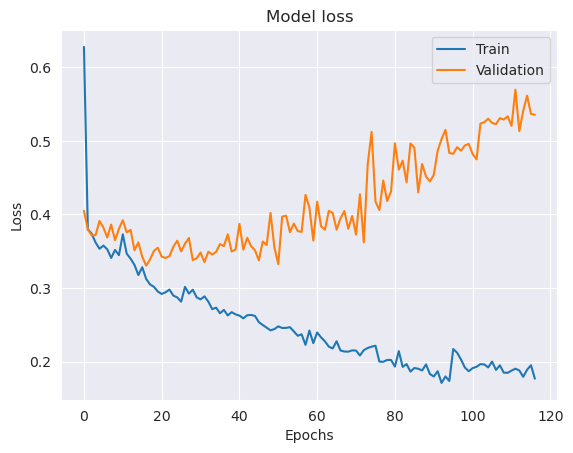

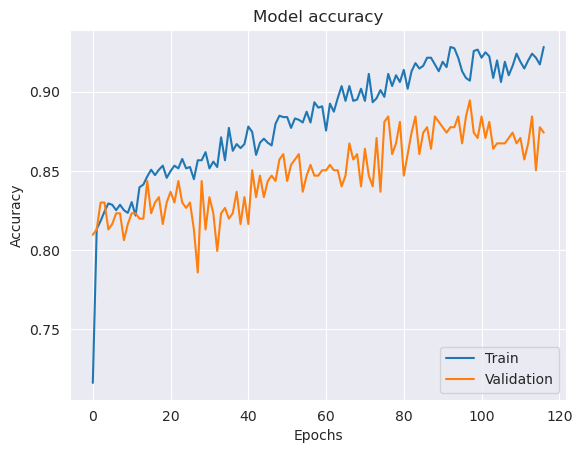

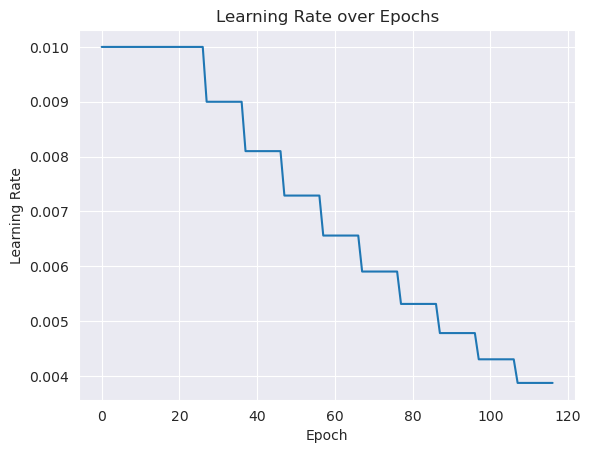

In [10]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plotting
# plt.figure(figsize=(8, 8))
plt.plot(lr_tracker.learning_rates)
plt.title("Learning Rate over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)

In [11]:
# Save the model
tf.keras.models.save_model(model, '/home/adam/FurtherResearch/Model/Exoskeleton/FeatureReduced/exo_model_top10')

2024-03-04 22:59:31.667647: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/adam/FurtherResearch/Model/Exoskeleton/FeatureReduced/exo_model_top10/assets


In [12]:
from tensorflow.keras.models import Model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
Total params: 943
Trainable params: 943
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Assume 'original_model' is your pre-trained model
model_without_softmax = Model(inputs=model.input, 
                              outputs=model.get_layer("dense_2").output)
model_without_softmax.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0_input (InputLayer)   [(None, 10)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 931
Trainable params: 931
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Save the model
tf.keras.models.save_model(model_without_softmax, '/home/adam/FurtherResearch/Model/Exoskeleton/FeatureReduced/exo_model_top10_without_softmax')

INFO:tensorflow:Assets written to: /home/adam/FurtherResearch/Model/Exoskeleton/FeatureReduced/exo_model_top10_without_softmax/assets
